# ``VAE2d`` Demo

To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``. To demonstrate ``torch_tools.VAE2d``, we use it to encode and decode MNIST images.

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, RandomRotation
from torchvision.transforms import ColorJitter
from torch.utils.data import DataLoader

batch_size = 100


training_tfms = Compose(
    [
        ToTensor(),
        RandomRotation(180),
        ColorJitter(brightness=0.5, contrast=0.5, hue=0.5, saturation=0.5),
    ]
)
valid_tfms = Compose([ToTensor()])


train_set = MNIST(
    root="/home/jim/storage/mnist/",
    train=True,
    download=True,
    transform=training_tfms,
)

valid_set = MNIST(
    root="/home/jim/storage/mnist/",
    train=False,
    download=True,
    transform=valid_tfms,
)


print(f"There are {len(train_set)} training items.")
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

print(f"The image size is '{train_set[0][0].shape}'")

valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

There are 60000 training items.
The image size is 'torch.Size([1, 28, 28])'


In this demo, we want bother with a validation loop during training, and will just use the validation set to do some inference at the end. Let's instantiate the model.

In [2]:
from torch.cuda import is_available
from torch import manual_seed

from torch_tools import VAE2d

manual_seed(123)


DEVICE = "cuda" if is_available() else "cpu"

model = VAE2d(
    in_chans=1,
    out_chans=1,
    start_features=16,
    input_dims=(28, 28),
    num_layers=3,
    max_down_feats=64,
    min_up_feats=3,
    block_style="conv_res"
).to(DEVICE)

print(f"Device set to {DEVICE}")

print(model)

Device set to cuda
VAE2d(
  (encoder): Encoder2d(
    (0): ConvResBlock(
      (0): ConvBlock(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ResidualBlock(
        (first_conv): ConvBlock(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.0)
        )
        (second_conv): ConvBlock(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      

Now, we set up the optimiser and loss function.

In [3]:
from torch.optim import Adam
from torch.nn import L1Loss

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = L1Loss()

And now we write our training loop.

In [4]:
from torch.nn import Module


def train_one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Adam,
    loss_func: L1Loss,
) -> float:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    optimiser : Adam
        Adam optimiser.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.train()
    metrics = {"l1_loss": 0.0, "kl_loss": 0.0}
    for batch, _ in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds, kl_div = model(batch)

        l1_loss = loss_func(preds.tanh(), batch)

        (l1_loss + kl_div).backward()

        optimiser.step()

        metrics["l1_loss"] += l1_loss.item()
        metrics["kl_loss"] += kl_div.item()

    return {key: val / len(data_loader) for key, val in metrics.items()}


def validate_one_epoch(
    model: Module,
    data_loader: DataLoader,
    loss_func: L1Loss,
) -> float:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.eval()
    metrics = {"l1_loss": 0.0}
    for batch, _ in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds = model(batch)

        l1_loss = loss_func(preds.tanh(), batch)

        l1_loss.backward()

        optimiser.step()

        metrics["l1_loss"] += l1_loss.item()

    return {key: val / len(data_loader) for key, val in metrics.items()}

Now we can train the model.

In [5]:
from time import perf_counter

epochs = 100

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start = perf_counter()

    train_metrics.append(
        train_one_epoch(
            model,
            train_loader,
            optimiser,
            loss_func,
        )
    )

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

    stop = perf_counter()

    print(f"{epoch + 1} Epoch time : {stop - start:.6f}")

1 Epoch time : 18.297083
2 Epoch time : 17.915416
3 Epoch time : 17.825539
4 Epoch time : 17.813252
5 Epoch time : 17.765147
6 Epoch time : 17.666868
7 Epoch time : 17.774679
8 Epoch time : 17.801590
9 Epoch time : 17.803737
10 Epoch time : 17.814515
11 Epoch time : 17.790474
12 Epoch time : 17.677565
13 Epoch time : 17.781833
14 Epoch time : 17.818770
15 Epoch time : 17.833768
16 Epoch time : 17.788084
17 Epoch time : 17.785122
18 Epoch time : 17.722656
19 Epoch time : 17.810777
20 Epoch time : 17.784524
21 Epoch time : 17.810033
22 Epoch time : 17.802058
23 Epoch time : 17.753797
24 Epoch time : 17.798028
25 Epoch time : 17.791825
26 Epoch time : 17.794970
27 Epoch time : 17.816618
28 Epoch time : 17.806065
29 Epoch time : 17.732435
30 Epoch time : 17.762475
31 Epoch time : 17.784309
32 Epoch time : 17.808369
33 Epoch time : 17.790844
34 Epoch time : 17.798606
35 Epoch time : 17.737214
36 Epoch time : 17.726898
37 Epoch time : 17.783847
38 Epoch time : 17.830061
39 Epoch time : 17.81

    l1_loss_train   kl_loss  l1_loss_valid
0        0.121240  0.016979       0.061873
1        0.080887  0.018612       0.042466
2        0.068796  0.019984       0.036012
3        0.059330  0.020532       0.030330
4        0.050423  0.019948       0.027344
..            ...       ...            ...
95       0.033208  0.019674       0.015847
96       0.033124  0.019694       0.015413
97       0.033114  0.019682       0.015203
98       0.033092  0.019676       0.015480
99       0.033134  0.019682       0.015327

[100 rows x 3 columns]


Text(0, 0.5, 'Loss')

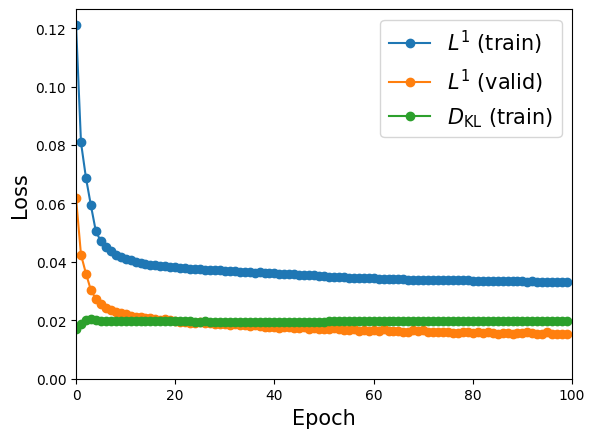

In [6]:
import matplotlib.pyplot as plt
from pandas import DataFrame

metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)

print(metrics)

figure, axes = plt.subplots(1, 1)
axes.plot(metrics["l1_loss_train"], "-o", label=r"$L^{1}$ (train)")
axes.plot(metrics["l1_loss_valid"], "-o", label="$L^{1}$ (valid)")
axes.plot(metrics["kl_loss"], "-o", label=r"$D_{\mathrm{KL}}$ (train)")


axes.set_ylim(bottom=0.0)
axes.set_xlim(left=0.0, right=epochs)

axes.legend(fontsize=15)

axes.set_xlabel("Epoch", fontsize=15)
axes.set_ylabel("Loss", fontsize=15)

In [7]:
for batch, target in valid_loader:
    break

Now we can take a look at some predictions from the validation loader.


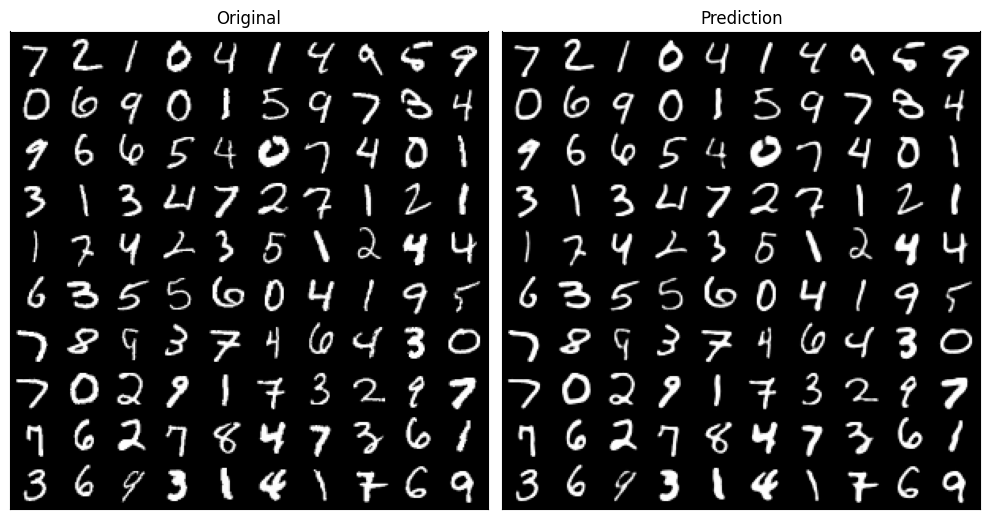

In [8]:
plt.close("all")

from torch import no_grad
from torchvision.utils import make_grid

with no_grad():
    model.eval()
    preds = model(batch.to(DEVICE)).tanh().detach()


batch_grid = make_grid(batch.cpu(), nrow=10).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=10).permute(1, 2, 0)


pred_grid = pred_grid.clip(0.0, 1.0)


figure, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_title("Original")
axes[1].set_title("Prediction")

figure.tight_layout(h_pad=0.05)